##### Copyright 2019 The TensorFlow Authors
Adapted by Waylay to create an example to save the model such that it can normalize input and denormalize output.

Orginal example can be found here: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.keras.backend.set_floatx('float64')

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">[weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 1s 0us/step


In [4]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [6]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [7]:
tf.random.set_seed(13)

## Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [8]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [9]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

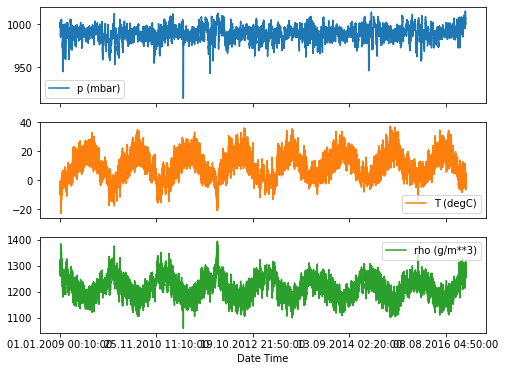

In [10]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [11]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [12]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [13]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [14]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [15]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [17]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [18]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [19]:
EVALUATION_INTERVAL = 200
EPOCHS = 10


single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 41s 204ms/step - loss: 0.3157 - val_loss: 0.2729
Epoch 2/10
200/200 [==============================] - 42s 210ms/step - loss: 0.2622 - val_loss: 0.2462
Epoch 3/10
200/200 [==============================] - 45s 225ms/step - loss: 0.2591 - val_loss: 0.2466
Epoch 4/10
200/200 [==============================] - 43s 213ms/step - loss: 0.2590 - val_loss: 0.2349
Epoch 5/10
200/200 [==============================] - 41s 205ms/step - loss: 0.2255 - val_loss: 0.2307
Epoch 6/10
200/200 [==============================] - 40s 201ms/step - loss: 0.2390 - val_loss: 0.2603
Epoch 7/10
200/200 [==============================] - 45s 223ms/step - loss: 0.2415 - val_loss: 0.2544
Epoch 8/10
200/200 [==============================] - 40s 199ms/step - loss: 0.2402 - val_loss: 0.2401
Epoch 9/10
200/200 [==============================] - 41s 206ms/step - loss: 0.2415 - val_loss: 0.2428
Epoch 10/10
200/200 [=========

In [20]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

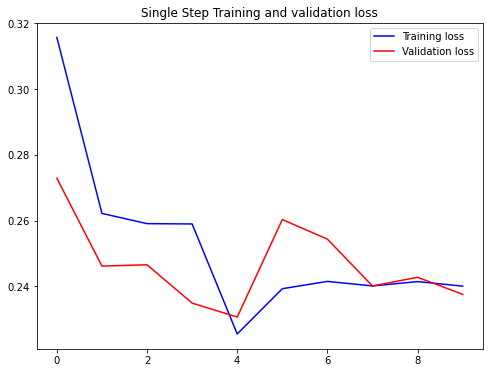

In [21]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

In [22]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

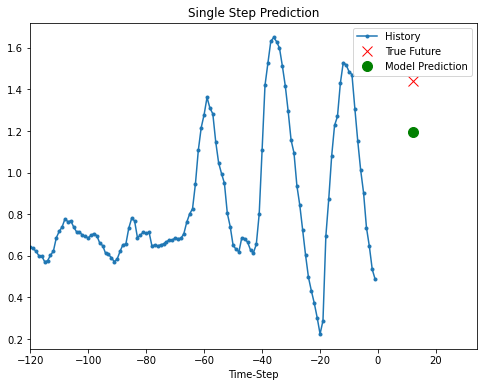

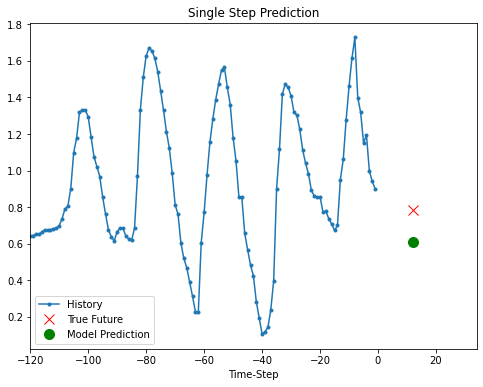

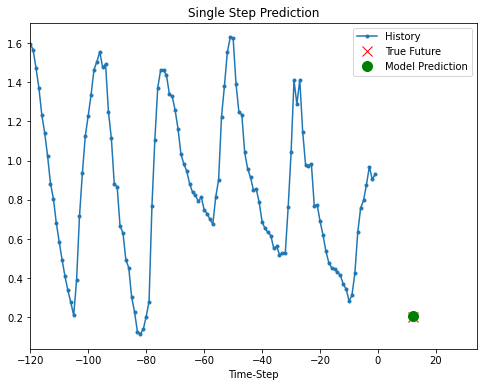

In [23]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [24]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [25]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [26]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [27]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

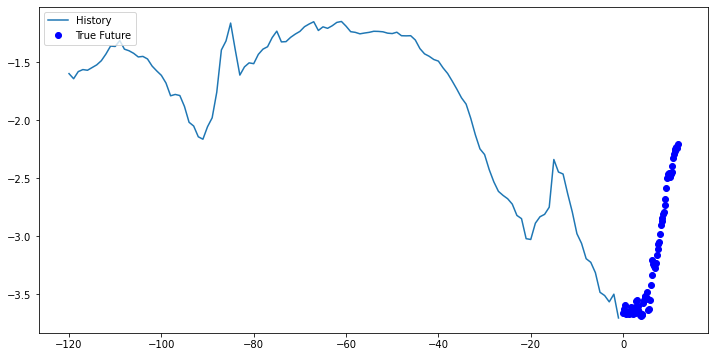

In [28]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [29]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [30]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [31]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 78s 388ms/step - loss: 0.4793 - val_loss: 0.2918
Epoch 2/10
200/200 [==============================] - 69s 344ms/step - loss: 0.4048 - val_loss: 0.2918
Epoch 3/10
200/200 [==============================] - 73s 365ms/step - loss: 0.3226 - val_loss: 0.2535
Epoch 4/10
200/200 [==============================] - 72s 359ms/step - loss: 0.2491 - val_loss: 0.2179
Epoch 5/10
200/200 [==============================] - 72s 359ms/step - loss: 0.2008 - val_loss: 0.2117
Epoch 6/10
200/200 [==============================] - 66s 328ms/step - loss: 0.2112 - val_loss: 0.2040
Epoch 7/10
200/200 [==============================] - 64s 319ms/step - loss: 0.2039 - val_loss: 0.2107
Epoch 8/10
200/200 [==============================] - 57s 287ms/step - loss: 0.2007 - val_loss: 0.1916
Epoch 9/10
200/200 [==============================] - 60s 302ms/step - loss: 0.2040 - val_loss: 0.1950
Epoch 10/10
200/200 [=========

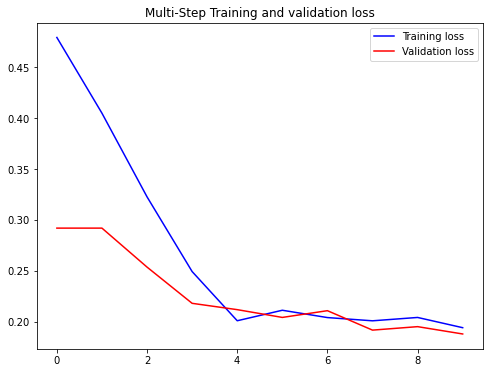

In [32]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

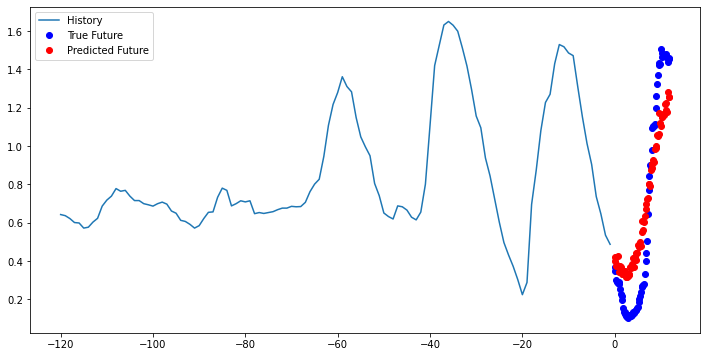

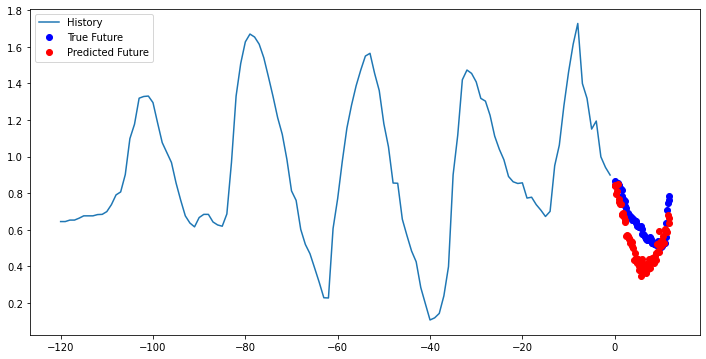

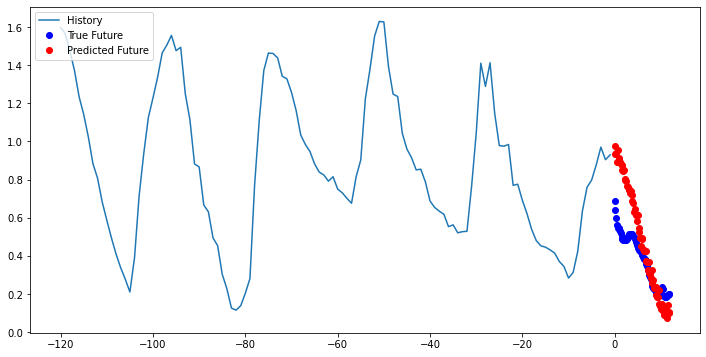

In [33]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Saving the multi step model for production

The multi step model expects the input to be normalized using the `data_mean` and `data_std` variables. The output of the model is in this normalized range as well. In production we do not know how this model is normalized, so this model should be able to handle the raw values.

In the example below we create a simple function that takes the 3 features, transforms them to shapes the model knows, and then transforms the output back to values the user of the model expects. In more detail:

- Say the input is `[None, 4]` instead of `[None, 120]`, if the user specifies 2 input samples this looks like:
```python
p = [[1000, 1001, 1002], [1002, 1004, 1006]]
T = [[7, 8, 7], [9, 7, 8]]
rho = [[1200, 1201, 1199], [1140, 1160, 1180]]
```

- Transposing `[p, T, rho]` using the `(1, 2, 0)` axes creates a Tensor with the correct shape for the model:
```python
  [[[1000,    7, 1200],
    [1001,    8, 1201],
    [1002,    7, 1199]],

   [[1002,    9, 1140],
    [1004,    7, 1160],
    [1006,    8, 1180]]]
```
- Then we normalize the data the same way, we normalized the training data and feed it to the model.
- The last step is then denormalizing the outputs of the model and returning them

In [34]:
class NormalizeDenormalizeModel(tf.Module):

    def __init__(self, model):
        self.model = model
        
    @tf.function(input_signature=[
        tf.TensorSpec([None, 120], dtype='float64', name='p'),
        tf.TensorSpec([None, 120], dtype='float64', name='T'),
        tf.TensorSpec([None, 120], dtype='float64', name='rho'),
        
    ])
    def normalize(self, p, T, rho):
        return self.model((tf.transpose([p, T, rho], (1,2,0)) - data_mean) / data_std) * data_std[1] + data_mean[1]

In [35]:
normalizer = NormalizeDenormalizeModel(multi_step_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: normalizer/assets


In [36]:
from waylay import WaylayClient
waylay = WaylayClient.from_profile()


In [39]:
model_name = 'tensorflow-normalize'
waylay.byoml.model.upload(
    model_name=model_name, 
    trained_model=normalizer, 
    framework='tensorflow', 
    description=(
        'A multi-variate multi-step timeseries model that expects the following features: '
        '"p" in mbar, "T" in degrees celcius, "rho" in gram per kubic metre'
    )
)

INFO:tensorflow:Assets written to: /var/folders/07/zn347xhn33z8m79l8xtz1hn80000gp/T/tmpzy1f_tb_/assets


{'message': 'Model successfully uploaded'}

In [52]:
instances = {
    'p': features[features_considered[0]].values.tolist()[:120],
    'T': features[features_considered[1]].values.tolist()[:120],
    'rho': features[features_considered[2]].values.tolist()[:120],
}

## Check if the output is the same

In [53]:
normalizer.normalize(
    [instances['p']],
    [instances['T']],
    [instances['rho']]
).numpy()[0][:10]

array([-5.03729025, -5.57934561, -5.18834417, -5.57537535, -5.19531047,
       -5.44799813, -5.22945312, -5.47546721, -5.35021676, -5.47606992])

In [54]:
waylay.byoml.model.predict(model_name, [instances])[0][:10]


array([-5.03729025, -5.57934561, -5.18834417, -5.57537535, -5.19531047,
       -5.44799813, -5.22945312, -5.47546721, -5.35021676, -5.47606992])